## Постановка задачи
Разберем архитектуру ResNet для решения задач распознавания изображений. Построим эту нейросеть для анализа исходных изображений.

Используя обученную модель, построим предсказания и классификацию, используя LightGBM. Проведем оценку качества предсказания по коэффициенту сходства.

Данные:
* https://video.ittensive.com/machine-learning/clouds/train.csv.gz (54 Мб)
* https://video.ittensive.com/machine-learning/clouds/train_images_small.tar.gz (212 Мб)

Соревнование: https://www.kaggle.com/c/understanding_cloud_organization/

© ITtensive, 2020

![](resnet.01.png)
![](resnet.02.png)

### Подключение библиотек

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
from skimage import io
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Activation, GlobalMaxPooling2D
from keras.applications.resnet50 import ResNet50,preprocess_input, decode_predictions
import lightgbm as lgb
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

Using TensorFlow backend.


### Используемые функции

In [2]:
filesDir = "train_images_small"
batch_size = 20
image_x = 224 # 525
image_y = 224 # 350
image_ch = 3 # 3
def mask_rate (a, x, y):
    b = a//1400 + 0.0
    return np.round(x*(b*x//2100) + y*(a%1400)//1400).astype("uint32")

def calc_mask (px, x=image_x, y=image_y):
    p = np.array([int(n) for n in px.split(' ')]).reshape(-1,2)
    mask = np.zeros(x*y, dtype='uint8')
    for i, l in p:
        mask[mask_rate(i, x, y) - 1:mask_rate(l+i, x, y)] = 1
    return mask.reshape(y,x).transpose()

def calc_dice (x):
    dice = 0
    px = x["EncodedPixels"] 
    if px != px and x["target"] == 0:
        dice = 1
    elif px == px and x["target"] == 1:
        mask = calc_mask(px).flatten()
        target = np.ones(image_x*image_y, dtype='uint8')
        dice += 2*np.sum(target[mask==1])/(np.sum(target)+np.sum(mask))
    return dice

def load_y (df):
    return np.array(df["EncodedPixels"].notnull().astype("int8")).reshape(len(df), 1)

def load_x (df):
    x = [[]]*len(df)
    for j, file in enumerate(df["Image"]):
        img = image.load_img(os.path.join(filesDir, file),
                     target_size=(image_y, image_x))
        img = image.img_to_array(img)
        x[j] = np.expand_dims(img, axis=0)
    return np.array(x).reshape(len(df), image_y, image_x, image_ch)

def load_data (df, batch_size):
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < len(df):
            limit = min(batch_end, len(df))
            yield (load_x(df[batch_start:limit]),
                   load_y(df[batch_start:limit]))
            batch_start += batch_size
            batch_end += batch_size

def draw_prediction (prediction):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1,1,1)
    ax.hist(prediction[0])
    ax.set_title("Fish")
    plt.show()

### Загрузка данных

In [3]:
data = pd.read_csv('https://video.ittensive.com/machine-learning/clouds/train.csv.gz')

In [4]:
data["Image"] = data["Image_Label"].str.split("_").str[0]
data["Label"] = data["Image_Label"].str.split("_").str[1]
data.drop(labels=["Image_Label"], axis=1, inplace=True)
data_fish = data[data["Label"] == "Fish"]
print (data_fish.head())

                                        EncodedPixels        Image Label
0   264918 937 266318 937 267718 937 269118 937 27...  0011165.jpg  Fish
4   233813 878 235213 878 236613 878 238010 881 23...  002be4f.jpg  Fish
8   3510 690 4910 690 6310 690 7710 690 9110 690 1...  0031ae9.jpg  Fish
12                                                NaN  0035239.jpg  Fish
16  2367966 18 2367985 2 2367993 8 2368002 62 2369...  003994e.jpg  Fish


### Разделение данных
Разделим всю выборку на 2 части случайным образом: 80% - для обучения модели, 20% - для проверки точности модели.

In [5]:
train, test = train_test_split(data_fish, test_size=0.2)
train = pd.DataFrame(train)
test = pd.DataFrame(test)
del data
print (train.head())

      EncodedPixels        Image Label
21784           NaN  fafc316.jpg  Fish
6076            NaN  4623c6c.jpg  Fish
8624            NaN  624f5eb.jpg  Fish
16760           NaN  c200cce.jpg  Fish
7392            NaN  548cb15.jpg  Fish


### ResNet-50
Подключим обученную нейросеть (90 Мб) и построим поверх классификатора LightGBM.

In [6]:
model = ResNet50(weights="imagenet")

W0325 23:38:42.359072 11888 deprecation_wrapper.py:119] From c:\users\nikolay\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0325 23:38:42.456077 11888 deprecation_wrapper.py:119] From c:\users\nikolay\appdata\local\programs\python\python37\lib\site-packages\keras\backend\tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



In [7]:
train_prediction = model.predict_generator(load_data(train, 1),
                            steps=len(train), verbose=1)

4436/4436 [==============================] - 3257s 734ms/step


### Обучение LightGBM по результатам ResNet

In [9]:
model_lgb = lgb.LGBMRegressor(random_state=17)
model_lgb.fit(pd.DataFrame(train_prediction),
             train["EncodedPixels"].notnull().astype("i1"))

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=17, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [10]:
prediction = model_lgb.predict(train_prediction)

In [11]:
prediction = np.array(prediction).reshape(1, -1)

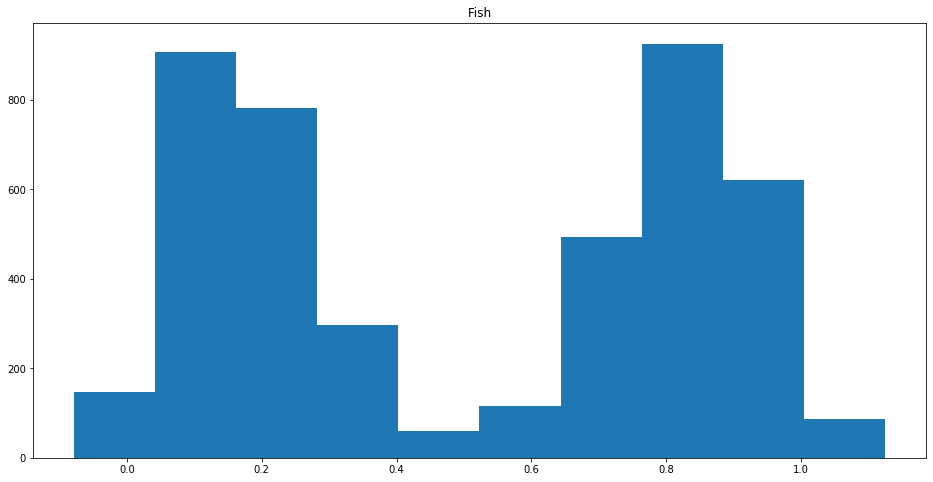

In [12]:
draw_prediction (prediction)

In [14]:
train["target"] = (prediction[0] > 0.75).astype("i1")
print (train[train["target"]>0]["EncodedPixels"])

18032    217001 491 218401 491 219801 491 221201 491 22...
16864    1582201 906 1583601 906 1585001 906 1586401 90...
12776    1095518 646 1096918 646 1098318 646 1099718 64...
2372     14010 398 15410 398 16810 398 18210 398 19610 ...
12996    200647 533 202047 533 203447 533 204847 533 20...
1432     87 809 1487 809 2887 809 4287 809 5687 809 708...
1056     548972 709 550372 709 551772 709 553172 709 55...
18680    103729 652 105129 652 106529 652 107929 652 10...
9476     966001 874 967401 874 968801 874 970201 874 97...
11116    20371 472 21771 472 23171 472 24571 472 25971 ...
19524    214947 587 216347 587 217747 587 219147 587 22...
8952     141 567 1541 567 2941 567 4341 567 5741 567 71...
7812     256 983 1656 983 3056 983 4456 983 5856 983 72...
20756    1528356 438 1529756 438 1531156 438 1532556 43...
3144     505401 216 506521 16 506541 4 506546 2 506549 ...
12916    9036 431 10436 431 11836 431 13236 431 14636 4...
14932    1050022 369 1050394 4 1050401 4 1051422 369 10.

In [15]:
dice = train.apply(calc_dice, axis=1, result_type="expand")
print ("Keras, Resnet-50+LightGBM, обучение:", round(dice.mean(), 3))

Keras, Resnet-50+LightGBM, обучение: 0.669


### Построение предсказания

In [16]:
test_prediction = model.predict_generator(load_data(test, 1),
                        steps=len(test), verbose=1)

1110/1110 [==============================] - 733s 661ms/step


In [17]:
prediction = model_lgb.predict(test_prediction)

In [18]:
prediction = np.array(prediction).reshape(1, -1)

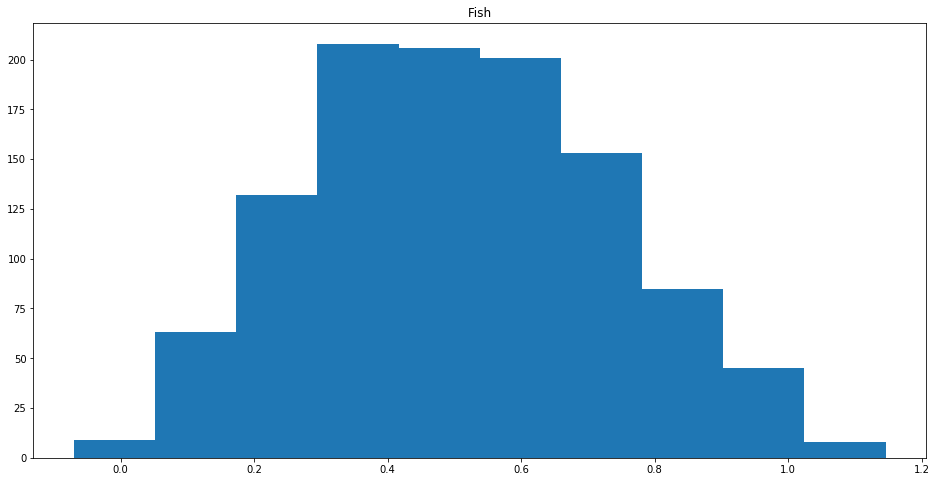

In [19]:
draw_prediction(prediction)

In [20]:
test["target"] = (prediction[0] > 0.75).astype("i1")

### Расчет точности предсказания
Нет облаков - 0.5, MLP - 0.3, CONV/VGG - 0.48, AlexNet - 0.21, Inception - 0.5

In [21]:
dice = test.apply(calc_dice, axis=1, result_type="expand")
print ("Keras, ResNet-50+LightGBM:", round(dice.mean(), 3))

Keras, ResNet-50+LightGBM: 0.553
